In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))
from collections import defaultdict
from glob import glob
from tqdm.auto import tqdm
import trimesh
from pclib.visualization import plot_point_cloud


# Collect data files

In [2]:
data_path = "../data"
categories = ["chair", "table"]

In [3]:
file_paths = defaultdict(list)

for category in tqdm(categories):
    category_files = glob(os.path.join(data_path, category, "*"))

    file_paths[category] = list(category_files)

  0%|          | 0/2 [00:00<?, ?it/s]

# Understanding the Point Cloud Class

## Visualizing Them

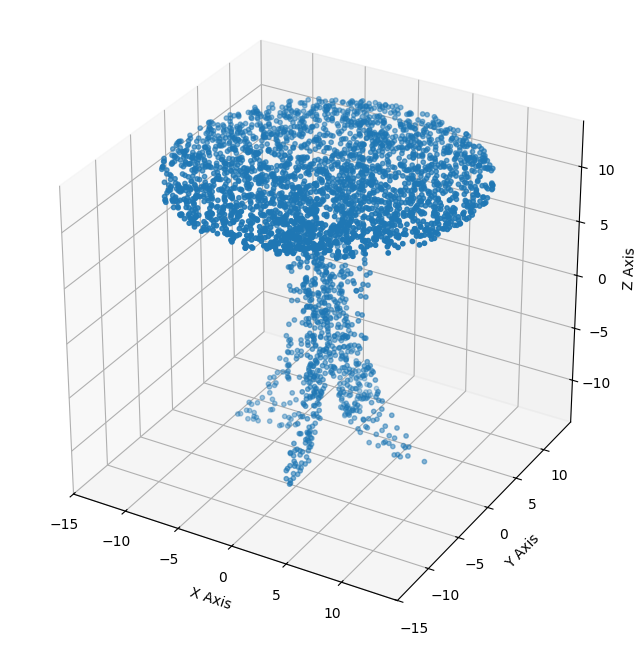

In [4]:
table_sample = trimesh.load(file_paths["table"][0])
plot_point_cloud(table_sample)

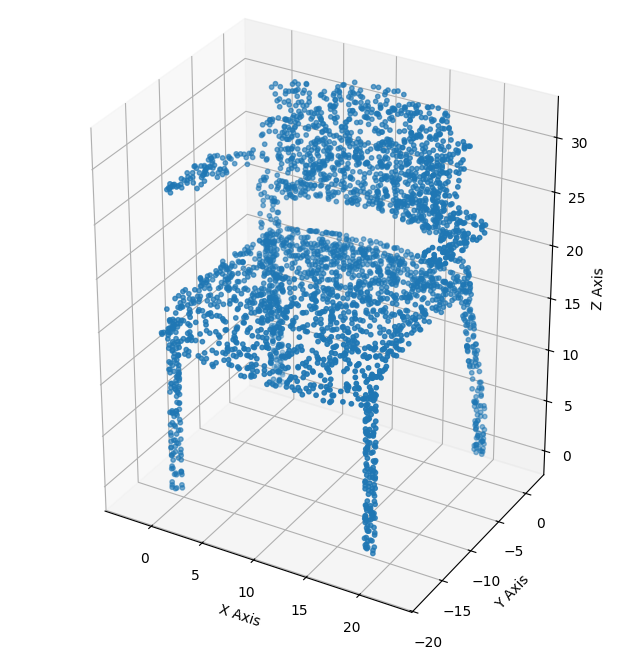

In [5]:
chair_sample = trimesh.load(file_paths["chair"][0])
plot_point_cloud(chair_sample)

In [6]:
import inspect

print("Attributes:", [m for m in dir(trimesh.PointCloud) if not callable(getattr(trimesh.PointCloud, m))])
print("Methods:", [m for m in dir(trimesh.PointCloud) if callable(getattr(trimesh.PointCloud, m))])

Attributes: ['__abstractmethods__', '__annotations__', '__dict__', '__doc__', '__module__', '__slots__', '__weakref__', '_abc_impl', 'bounding_box', 'bounding_box_oriented', 'bounding_cylinder', 'bounding_primitive', 'bounding_sphere', 'bounds', 'centroid', 'colors', 'convex_hull', 'extents', 'identifier', 'identifier_hash', 'is_empty', 'kdtree', 'moment_inertia', 'scale', 'shape', 'source', 'units', 'vertices', 'weights']
Methods: ['__add__', '__class__', '__delattr__', '__dir__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'apply_obb', 'apply_scale', 'apply_transform', 'apply_translation', 'copy', 'export', 'hash', 'merge_vertices', 'query', 'scene', 'show']


In [7]:
chair_sample.vertices.mean(axis=0)

TrackedArray([10.20726609, -6.34857675, 19.06078739])

## Testing out Transforms

In [8]:
from pclib.datasets import load_dataset
from pclib.datasets.data_transforms import BaseDataTransform, AffineTransfor3D

In [9]:
dataset = load_dataset(data_path, categories, dataset_type="transforms")

In [10]:
T = AffineTransfor3D(method="random")

isinstance(T, BaseDataTransform)

True

In [12]:
dataset.set_transforms([T])

In [13]:
dataset.transforms

In [14]:
data, label = dataset[7]

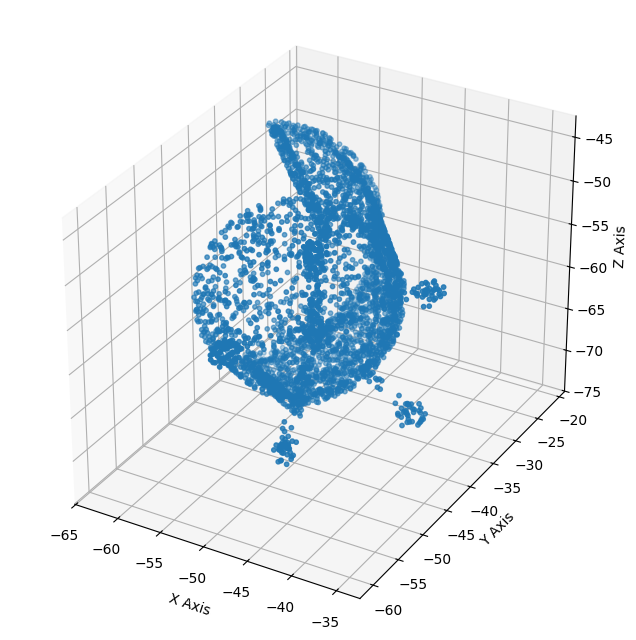

In [15]:
plot_point_cloud(data)

# Statistics

In [16]:
chair_count = len(file_paths["chair"])
table_count = len(file_paths["table"])

chair_count, table_count

(989, 492)

In [17]:
point_cloud_size_sum = 0
point_cloud_size_count = chair_count + table_count

for category, category_file_paths in tqdm(file_paths.items()):
    for file_path in tqdm(category_file_paths, desc=category):
        point_cloud_size_sum += trimesh.load(file_path).vertices.shape[0]

point_cloud_average_size = point_cloud_size_sum / point_cloud_size_count
point_cloud_average_size

  0%|          | 0/2 [00:00<?, ?it/s]

chair:   0%|          | 0/989 [00:00<?, ?it/s]

table:   0%|          | 0/492 [00:00<?, ?it/s]

7464.303173531398

In [20]:
file_paths['chair']

['../data/chair/chair_0900.ply',
 '../data/chair/chair_0914.ply',
 '../data/chair/chair_0082.ply',
 '../data/chair/chair_0928.ply',
 '../data/chair/chair_0096.ply',
 '../data/chair/chair_0069.ply',
 '../data/chair/chair_0041.ply',
 '../data/chair/chair_0727.ply',
 '../data/chair/chair_0733.ply',
 '../data/chair/chair_0055.ply',
 '../data/chair/chair_0280.ply',
 '../data/chair/chair_0294.ply',
 '../data/chair/chair_0519.ply',
 '../data/chair/chair_0525.ply',
 '../data/chair/chair_0243.ply',
 '../data/chair/chair_0257.ply',
 '../data/chair/chair_0531.ply',
 '../data/chair/chair_0492.ply',
 '../data/chair/chair_0486.ply',
 '../data/chair/chair_0479.ply',
 '../data/chair/chair_0451.ply',
 '../data/chair/chair_0337.ply',
 '../data/chair/chair_0323.ply',
 '../data/chair/chair_0445.ply',
 '../data/chair/chair_0874.ply',
 '../data/chair/chair_0860.ply',
 '../data/chair/chair_0690.ply',
 '../data/chair/chair_0848.ply',
 '../data/chair/chair_0684.ply',
 '../data/chair/chair_0109.ply',
 '../data/